<img src="https://avatars.githubusercontent.com/u/61354833" align="left" width="70" height="70">

Code by [TomMakesThings](https://github.com/TomMakesThings/Computational-Intelligence-Neural-Network)

# **About**

#### **Problem Definition**
The aim of this project is to train a feed-forward multi-layer perceptron network to approximate the following function:

$y = sin(2x_{1} + 2.0) + cos(0.5x_{2}) + 0.5$

$x_{1}, x_{2} \in [0, 2\pi]$

The neural network is fully connected and has two inputs, two bias neurons, six hidden neurons and one output. Sigmoid activation functions are used in the hidden neurons, and a linear activation function in the output neuron.

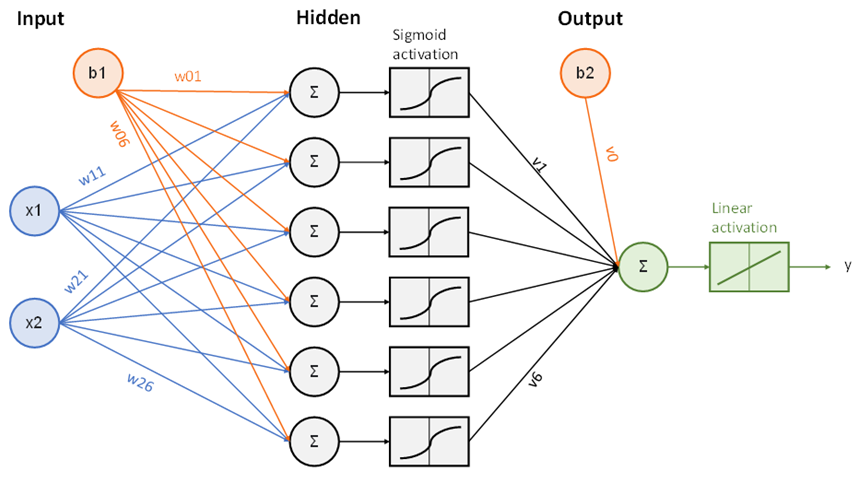

#### **Implementation**

**Training and Testing Data**

21 random values between $[0, 2\pi]$ are generated for $x_{1}$ and $x_{2}$ and added to lists retrospectively. These values are used to calculate a list of corresponding $y$ values. 11 sets of $x_{1}$, $x_{2}$, $y$ values are written to file `train.dat`, while the remaining values are written to file `test.dat`. 

<br>

**Encoding**

A binary coded genetic algorithm is used for optimising the weights of the neural network. Every individual in the population is initialised with 25 random 15-bit decision variables with each representing a network weight. This includes the weights from the bias nodes. The number of decision variables was calculated using the following formula:

$(INPUTS+1) \times HIDDEN + (HIDDEN+1) \times OUTPUTS$

Therefore, the number of weights in the network is:

$(2 + 1) \times 6 + (6 + 1) = 25$

Consequently, the total number of bits to encode the weights per individual is:

$15 \times 25 = 375$

<br>

**Population Initialisation and Evalution**

100 individuals are generated in each population. For each, their decision variables are converted from binary to their real value between the range $[-10, 10]$. The fitness function sets individual’s real-valued weights as the weights of the network and calculates the mean squared error. The loss value is then set as the individual’s fitness.

<br>

**Mate Selection and Crossover**

After evaluating fitness, individuals are randomly selected as parent pairs. 200 offspring are produced by applying uniform crossover with cross probability 0.95. This high cross probability creates variety within the weights. Similarly, with uniform crossover, if the two parents are different, the offspring are unlikely to be the same as either parent. Both factors ensure that the population maintains high genetic diversity preventing the population getting stuck at a local minimum.

<br>

**Mutation**

Point mutation is applied to each newly generated offspring with probability:

$p = \frac{1}{\text{n bits} \times \text{n decision variables}}$

This means that on average, there will be one mutation per chromosome. Keeping this value low prevents the population from changing too rapidly to allow convergence to an optimum weight set. However, a small amount of mutation helps introduce new variation that may not be possible from parent crossover alone.

<br>

**Selection**

The offspring's fitness is evaluated and k-elitism is used to select the top 100 offspring pass on to the next generation. Selecting the best individuals speeds up convergence over other methods such as rank proportionate.

<br>

**Running the Neural Network**

The genetic algorithm is set to run 40 times to optimise the weights of the network. In each generation, if no lifetime learning method is set then an individuals’ fitness is the MSE on training data. After training within each generation, the individual with the highest MSE is recorded and this individual is then evaluated against testing data. The MSE of these best individuals are then plotted.

The maximum number of generations has been set as 40 as the MSE generally converges after this number (left graph). If further generations are run, this will lead to overfitting of training data (right graph).


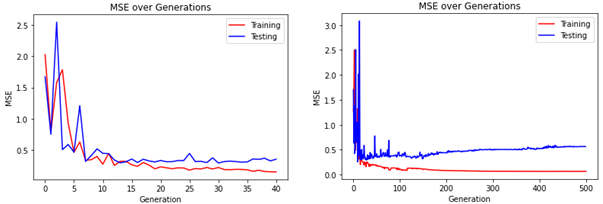

**Lamarckian Learning Approach**

Genetic algorithms are great at exploring a search space, but not good at converging. Therefore a memetic algorithm can be introduced to extend the genetic algorithm to use a local search.

Instead of evaluating the fitness of an individual’s decision variables at initialisation, fitness can be assigned after lifetime learning through local search. During local search, the individual’s decision variables are set as the weights for the network. For 30 iterations, the network is trained using Rprop, a method that uses the gradient to update the network weights. After the local search is complete, the updated weights and MSE are returned.

The new weights are converted from real valued to binary by reversing the formulae for conversion from binary to real valued. The individual’s corresponding decision variables are updated with these new weights and the new fitness assigned. As the individual's decision variables are updated and passed to offspring, this is Lamarckian learning.

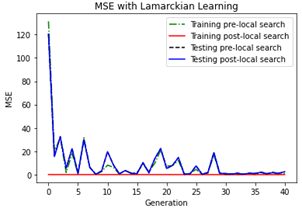

**Baldwinian Learning Approach**

With the Baldwinian learning approach, Rprop learning is used to improve fitness, as implemented with Lamarckian learning. However, an individual’s decision variables are not changed after learning and therefore are not passed onto offspring. By not inheriting the improved weights, it takes longer for individuals in the Baldwinian population to improve and converge to an optimum.


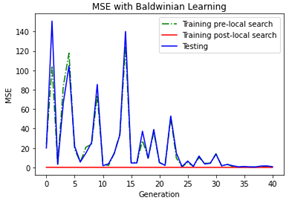

# **Imports**

In [ ]:
!pip install deap

import torch
import torch.nn as nn
import random
import math
import numpy as np
import matplotlib.pyplot as plot

from numpy import genfromtxt
from deap import base, creator, tools
from sympy.combinatorics.graycode import random_bitstring

     |████████████████████████████████| 163kB 8.5MB/s 


# **Constants**

In [ ]:
# Number of training and testing samples
TRAIN_NUMBER, TEST_NUMBER = 11, 10
TOTAL_SAMPLES = TRAIN_NUMBER + TEST_NUMBER
# 0 <= x1,x2 <= 2π
X_LOWER_BOUND, X_UPPER_BOUND = 0, math.pi*2

# Number of inputs
INPUTS = 2
# Number of hidden neurons
HIDDEN = 6
# Number of outputs
OUTPUTS = 1

# Number of bits to encode weights
WEIGHT_BITS = 15
# Number of decision variables
DECISION_VARIABLES = (INPUTS+1)*HIDDEN + (HIDDEN+1)*OUTPUTS
# - 10 <= weight <= 10
WEIGHT_LOWER_BOUND, WEIGHT_UPPER_BOUND = - 10, 10

POPULATION_SIZE = 100
# Number of iterations
NUMBER_OF_GENERATIONS = 40
CROSS_PROBABILITY = 0.95
MUTATION_PROBABILITY = 1/(WEIGHT_BITS * DECISION_VARIABLES)

LEARNING_RATE_ITERATIONS = 30

random.seed(10)

# **Network Class**

In [ ]:
class Net(nn.Module):
  def __init__(self, feature_number, hidden_number, output_number):
    super(Net, self).__init__()
    # Fully connected hidden layer
    self.hidden = nn.Linear(feature_number, hidden_number)
    # Fully connected output layer
    self.out = nn.Linear(hidden_number, output_number)

  def forward(self, x):
    # Pass x through the hidden layer
    x = self.hidden(x)
    # Apply the sigmoid activation function
    x = torch.sigmoid(x)
    # Pass x through the output layer
    x = self.out(x)
    return x

# **Functions**

In [ ]:
def generate_samples(samples_number, lower_limit, upper_limit):
  """ Generates a given number of samples between two limits """
  samples = []
  for i in range(samples_number):
    # Creates a random value
    sample = random.uniform(lower_limit, upper_limit)
    samples.append(sample)
  return samples

In [ ]:
def calculate_y(x1_values, x2_values):
  """ Calculates the y values for a list of x1 and x2 values """
  y_values = []
  for i in range(len(x1_values)):
    y = math.sin(2*x1_values[i] + 2) * math.cos(0.5 * x2_values[i]) + 0.5
    y_values.append(y)
  return y_values

In [ ]:
def write_samples_to_file(x1, x2, y, filename):
  """ Writes lists of x1, x2, y values to file
  File format: x1 x2 y """
  file = open(filename, "w")
  for i in range(len(x1)):
    # Stores in format: x1 x2 y
    file.write(str(x1[i]) + " " + str(x2[i]) + " " + str(y[i]) + "\n")

In [ ]:
def plot_dataset(x_data, y_data, title, point='ro'):
  """ Plot x1, x2, y values """
  plot.figure()
  axes = plot.axes(projection ='3d')
  # x1 values
  x = [x_data[i][0] for i in range(len(x_data))]
  # x2 values
  y = [x_data[i][1] for i in range(len(x_data))]
  # y values
  z = [y_data[i][0] for i in range(len(y_data))]

  axes.plot3D(x, y, z, point)
  axes.set_title(title)
  axes.set_xlabel('x1')
  axes.set_ylabel('x2')
  axes.set_zlabel('y ')
  plot.show()

In [ ]:
def binary_to_real(binary, lower, upper):
  """ Takes a binary number and converts it to a real number in range [lower, upper] """
  bits = len(binary)
  integer = int(binary, 2)
  # Converts to real-valued
  real = lower + (upper - lower) * (1 / (2**bits  - 1)) * integer
  return real

In [ ]:
def real_to_binary(real, lower, upper, bits):
  """ Takes a real number and converts it to binary """
  # Reverse of binary_to_real
  integer = round((real - lower) / ((upper - lower) * (1 / (2**bits  - 1))))
  # Converts integer to binary string
  binary = bin(integer)
  # Ignore 'b' at beginning
  binary = binary.split('b')[1]
  # Add 0s to start if less than specified number of bits
  if len(binary) < bits:
    zeros = "0" * (bits - len(binary))
    binary = zeros + binary
  return binary

In [ ]:
def set_weights(network, weights):
  """ Set network weights """
  count = 0
  # Iterates through network layers
  for layer in network.children():
    if isinstance(layer, torch.nn.Linear):
      # Set neuron weights
      for i in range(len(layer.weight)):
        for j in range(len(layer.weight[i])):
          layer.weight.data[i][j] = weights[count]
          count += 1
      # Set bias weights
      for b in range(len(layer.bias)):
        layer.bias.data[b] = weights[count]
        count += 1

In [ ]:
def calculate_loss(weights, network, loss_function, x_train, y_train):
  """ Calculates the loss of an individual's decision variables (weights) """
  set_weights(network, weights)
  output = network(x_train)
  loss = loss_function(output, y_train)
  l = loss.item()
  return l

In [ ]:
def local_search(weights, network, loss_function, search_method, iterations, x_train, y_train, approach="Baldwinian"):
  """ Perform local search for a given number of iterations """
  set_weights(network, weights)
  for i in range(iterations):
    output = network(x_train)
    loss = loss_function(output, y_train)
    # Clear gradients before backpropagation to prevent accumulation of gradients
    search_method.zero_grad()
    # Backpropagation to compute gradients
    loss.backward()
    # Update weights using gradients
    search_method.step()
    learned_loss = loss.item()

  # A network's updated weights are returned in Lamarckian learning
  updated_weights = []
  # Checks if Lamarckian learning
  if approach.lower()[0] == "l":
    # Get network's updated weights
    for layer in network.children():
      if isinstance(layer, torch.nn.Linear):
        # Converts layer's weights from tensor to list
        layer_weights = layer.weight.tolist()
        # Iterates through weights
        for i in range(len(layer_weights)):
          for j in range(len(layer_weights[i])):
            # Adds each weight to list
            updated_weights.append(layer_weights[i][j])
        layer_bias_weights = layer.bias.tolist()
        for b in range(len(layer_bias_weights)):
          updated_weights.append(layer_bias_weights[b])
  return learned_loss, updated_weights

In [ ]:
def k_elitism(population, k, minimization=True):
  """ Returns k individuals with the best fitness """
  copy_pop = toolbox.clone(population)
  if minimization:
    copy_pop.sort(key=lambda x: x.fitness.values[0])
  else:
    copy_pop.sort(key=lambda x: x.fitness.values[0], reverse=True)
  k_best = copy_pop[:k]
  return k_best

In [ ]:
def mate_select(population):
  """ Selects pairs of parents from population """
  pairs = []
  copy_pop = toolbox.clone(population)
  # Randomly change order of population
  random.shuffle(copy_pop)
  while len(copy_pop) > 2:
    # Select two parents
    p1, p2 = copy_pop[0], copy_pop[1]
    copy_pop.remove(p1)
    copy_pop.remove(p2)
    pairs.append([p1, p2])
  return pairs

In [ ]:
def flipMutation(individual, probability=0.1):
  # Iterates through decision variables
  for i in range(len(individual)):
    # Creates updated decision variable
    new_var = ""
    # Iterates through bits in decision variable
    for bit in individual[i]:
      new_bit = bit
      # Flip bit
      if random.random() <= probability:
        if bit == '0':
          new_bit = '1'
        if bit == '1':
          new_bit = '0'
      new_var += new_bit
    # Updates mutated decision variable
    individual[i] = new_var
  return individual

In [ ]:
def evaluate_population(weight_pop, real_weight_pop, learning, network, MSE, x_train, y_train, x_test, y_test, search_method):
  """ Evaluates and updates fitness of individuals in weight_pop
  Returns lists of fitness for all individuals on training and testing data """

  # Record fitness of weights pre-local search on test data
  pre_testing_fitnesses = []
  if learning.lower()[0] == "l":
    weight_pop_copy = toolbox.clone(real_weight_pop)
    for ind in weight_pop_copy:
      pre_testing_fitnesses.append(toolbox.evaluate(ind, network, MSE, x_test, y_test))

  # Evaluate fitness (MSE) of population
  pre_training_fitnesses = []
  training_fitnesses = []
  testing_fitnesses = []
  # Iterates through individual's real weight values
  for i in range(len(real_weight_pop)):
    ind = real_weight_pop[i]
    # Lamarckian or Baldwinian learning
    if learning.lower()[0] == "l" or learning.lower()[0] == "b":
      # Record fitness before lifetime learning
      pre_training_fitnesses.append(toolbox.evaluate(ind, network, MSE, x_train, y_train))
      # Fitness from training
      learned_loss, updated_weights = local_search(ind, network, MSE, search_method, LEARNING_RATE_ITERATIONS, x_train, y_train, learning)
      # Lamarckian learning
      if len(updated_weights) != 0:
        # Updates individual's weights
        for j in range(len(updated_weights)):
          real_weight = updated_weights[j]
          # Real valued weight to binary
          binary_weight = real_to_binary(real_weight, WEIGHT_LOWER_BOUND, WEIGHT_UPPER_BOUND, WEIGHT_BITS)
          # Updates weight
          weight_pop[i][j] = binary_weight
      # Loss after lifetime learning
      training_fitnesses.append(learned_loss)
    else:
      # Loss with no lifetime learning
      training_fitnesses.append(toolbox.evaluate(ind, network, MSE, x_train, y_train))
    testing_fitnesses.append(toolbox.evaluate(ind, network, MSE, x_test, y_test))
  for ind, fit in zip(weight_pop, training_fitnesses):
    # Assigns fitness to individual
    ind.fitness.values = [fit]
  return training_fitnesses, testing_fitnesses, pre_training_fitnesses, pre_testing_fitnesses

# **Toolbox Initialisation**

In [ ]:
# Creates a fitness for minimization of a single objective
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# Creates class Individual with fitness set for minimization
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generation function for decision variables using 10 bit binary
toolbox.register("binary_code", random_bitstring, WEIGHT_BITS)
# Initializers for individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.binary_code, DECISION_VARIABLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("evaluate", calculate_loss) # Uses evaluation function
toolbox.register("select", mate_select) # Mate selection
toolbox.register("mate", tools.cxUniform, indpb=0.5) # Uniform crossover with 50% chance of exchange
toolbox.register("mutate", flipMutation, probability=MUTATION_PROBABILITY) # Flip mutation with chance = 1 / chromosome length
toolbox.register("sort", k_elitism) # Select the k-best individuals

# **Generate Test and Train Data and Save to File**

In [ ]:
# 21 samples between [0, 2pi]
x1_samples = generate_samples(TOTAL_SAMPLES, X_LOWER_BOUND, X_UPPER_BOUND)
x2_samples = generate_samples(TOTAL_SAMPLES, X_LOWER_BOUND, X_UPPER_BOUND)
# y values of samples
y_samples = calculate_y(x1_samples, x2_samples)

# Training dataset
x1_train = x1_samples[:TRAIN_NUMBER]
x2_train = x2_samples[:TRAIN_NUMBER]
y_train = y_samples[:TRAIN_NUMBER]
write_samples_to_file(x1_train, x2_train, y_train, "train.dat")

# Testing dataset
x1_test = x1_samples[TRAIN_NUMBER:]
x2_test = x2_samples[TRAIN_NUMBER:]
y_test = y_samples[TRAIN_NUMBER:]
write_samples_to_file(x1_test, x2_test, y_test, "test.dat")

# **Set Up Testing and Training Data**

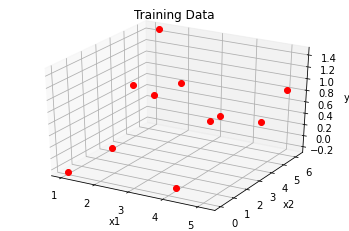

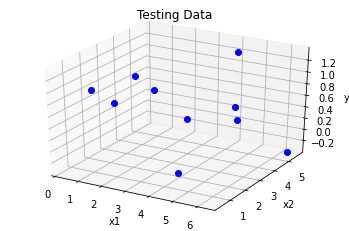

In [ ]:
training_data = genfromtxt('train.dat', delimiter=' ')

x_train = training_data[:, 0:2]
y_train = training_data[:, 2:3]
x_train = torch.as_tensor(x_train, dtype=torch.float32)
y_train = torch.as_tensor(y_train, dtype=torch.float32)

plot_dataset(x_train, y_train, 'Training Data')

testing_data = genfromtxt('test.dat', delimiter=' ')

x_test = testing_data[:, 0:2]
y_test = testing_data[:, 2:3]
x_test = torch.as_tensor(x_test, dtype=torch.float32)
y_test = torch.as_tensor(y_test, dtype=torch.float32)

plot_dataset(x_test, y_test, 'Testing Data', 'bo')

# **Train Network**


In [ ]:
def main(x_test, y_test, x_train, y_train, generations=50, learning="none"):
  # Initiate the network
  network = Net(feature_number=2, hidden_number=6, output_number=1)
  # Mean squared error loss function
  MSE = torch.nn.MSELoss()
  # Local search method
  search_method = torch.optim.Rprop(network.parameters(), lr=0.02)
  
  # Initiate the population of weights
  weight_pop = toolbox.population(POPULATION_SIZE)

  # Lists of best loss values
  pre_train_MSE = [] # Loss before lifetime learning on training, if learning is used
  pre_test_MSE = [] # Loss before lifetime learning on testing, if learning is used
  train_MSE = [] # Loss after training
  test_MSE = [] # Loss from testing

  # Convert the weights from binary to real
  real_weight_pop = []
  for ind in weight_pop:
    reals = []
    for weight in ind:
      reals.append(binary_to_real(weight, WEIGHT_LOWER_BOUND, WEIGHT_UPPER_BOUND))
    real_weight_pop.append(reals)

  # Evaluate and assign fitness (MSE) of population
  fitnesses = evaluate_population(weight_pop, real_weight_pop, learning, network, MSE, x_train, y_train, x_test, y_test, search_method)
  # Training post-local learning if learning applied, else just fitness from training
  training_fitnesses = fitnesses[0]
  # Testing post-local learning if learning applied, else just fitness from testing
  testing_fitnesses = fitnesses[1]
  # Training pre-local learning, empty if no learning used
  pre_training_fitnesses = fitnesses[2]
  # Testing pre-local learning, empty if no learning used
  pre_testing_fitnesses = fitnesses[3]

  # Record the best fitness (MSE)
  sorted_training_fitnesses = training_fitnesses.copy()
  # Finds the best in individual in training
  sorted_training_fitnesses.sort()
  best_fitness = sorted_training_fitnesses[0]
  # Finds the best individual's location in the training list
  index = training_fitnesses.index(best_fitness)
  train_MSE.append(best_fitness)
  # Find the same individual's fitness from testing
  test_MSE.append(testing_fitnesses[index])
  # Only runs if lifetime learning is applied
  if (len(pre_training_fitnesses) != 0):
    pre_train_MSE.append(pre_training_fitnesses[index])
  # Only runs if Lamarckian
  if (len(pre_testing_fitnesses) != 0):
    pre_test_MSE.append(pre_testing_fitnesses[index])

  for generation in range(generations):
    parent_pairs = toolbox.select(weight_pop) + toolbox.select(weight_pop)
    offspring = []
    for pair in parent_pairs:
      # Makes copies of parents to modify
      parent1 = toolbox.clone(pair[0])
      parent2 = toolbox.clone(pair[1])
      offspring1 = toolbox.clone(parent1)
      offspring2 = toolbox.clone(parent2)
      # Cross over
      if random.random() <= CROSS_PROBABILITY:
        toolbox.mate(offspring1, offspring2)
      # Mutate both offspring
      toolbox.mutate(offspring1)
      toolbox.mutate(offspring2)
      offspring.append(offspring1)
      offspring.append(offspring2)

    # Convert the offspring weights from binary to real
    real_weight_offspring = []
    for off in offspring:
      reals = []
      for weight in off:
        reals.append(binary_to_real(weight, WEIGHT_LOWER_BOUND, WEIGHT_UPPER_BOUND))
      real_weight_offspring.append(reals)

    # Update offspring fitness
    fitnesses = evaluate_population(offspring, real_weight_offspring, learning, network, MSE, x_train, y_train, x_test, y_test, search_method)
    training_fitnesses = fitnesses[0]
    testing_fitnesses = fitnesses[1]
    pre_training_fitnesses = fitnesses[2]
    pre_testing_fitnesses = fitnesses[3]

    # Record the best fitness (MSE)
    sorted_training_fitnesses = training_fitnesses.copy()
    # Finds the best in individual in training
    sorted_training_fitnesses.sort()
    best_fitness = sorted_training_fitnesses[0]
    print(best_fitness)
    # Finds the best individual's location in the training list
    index = training_fitnesses.index(best_fitness)
    train_MSE.append(best_fitness)
    test_MSE.append(testing_fitnesses[index])
    # Only runs if lifetime learning is applied
    if (len(pre_training_fitnesses) != 0):
      pre_train_MSE.append(pre_training_fitnesses[index])
    # Only runs if Lamarckian
    if (len(pre_testing_fitnesses) != 0):
      pre_test_MSE.append(pre_testing_fitnesses[index])

    # Use the fittest offspring as the next population
    weight_pop = toolbox.sort(offspring, POPULATION_SIZE)

  plot.figure()
  if learning.lower()[0] == "l":
    plot.title('MSE with Lamarckian Learning')
  elif learning.lower()[0] == "b":
    plot.title('MSE with Baldwinian Learning')
  else:
    plot.title('MSE over Generations')
  if learning.lower()[0] == "l" or learning.lower()[0] == "b":
    plot.plot(np.array(pre_train_MSE), 'g', label="Training pre-local search", linestyle="dashdot")
    plot.plot(np.array(train_MSE), 'r', label="Training post-local search")
    if learning.lower()[0] == "l":
      plot.plot(np.array(pre_test_MSE), color='black', label="Testing pre-local search", linestyle="dashed")
      plot.plot(np.array(test_MSE), 'b', label="Testing post-local search")
    else:
      plot.plot(np.array(test_MSE), 'b', label="Testing")
  else:
    plot.plot(np.array(train_MSE), 'r', label="Training")
    plot.plot(np.array(test_MSE), 'b', label="Testing")
  plot.xlabel('Generation')
  plot.ylabel('MSE')
  plot.legend()

  # Plot training separately if local learning applied
  if learning.lower()[0] == "l" or learning.lower()[0] == "b":
    plot.figure()
    if learning.lower()[0] == "l":
      plot.title('MSE with Lamarckian Learning')
    else:
      plot.title('MSE with Baldwinian Learning')
    plot.plot(np.array(train_MSE), 'r', label="Training")
    plot.xlabel('Generation')
    plot.ylabel('MSE')
    plot.legend()

  # Plot pre-training and pre-testing for Lamarckian
  if learning.lower()[0] == "l":
    plot.figure()
    plot.title('MSE with Lamarckian Learning')
    plot.plot(np.array(pre_train_MSE), 'g', label="Training pre-local search", linestyle="dashdot")
    plot.plot(np.array(pre_test_MSE), color='black', label="Testing pre-local search", linestyle="dashed")
    plot.xlabel('Generation')
    plot.ylabel('MSE')
    plot.legend()

  return weight_pop[0]

1.265393614768982
1.6694934368133545
0.7464504837989807
0.8647674322128296
1.0445640087127686
0.47605571150779724
1.2989991903305054
0.6124034523963928
0.3862616717815399
0.494582861661911
0.3685072660446167
0.3414582908153534
0.30420246720314026
0.2557540237903595
0.22723247110843658
0.2207939475774765
0.22409552335739136
0.20546108484268188
0.24288082122802734
0.2121962606906891
0.21200576424598694
0.2052910476922989
0.21511545777320862
0.20926323533058167
0.19814077019691467
0.20909036695957184
0.2197912186384201
0.22526246309280396
0.17866243422031403
0.2070738673210144
0.21295680105686188
0.2119881510734558
0.20521625876426697
0.17510339617729187
0.19957520067691803
0.19972233474254608
0.1972493678331375
0.18091945350170135
0.1749311089515686
0.16714979708194733


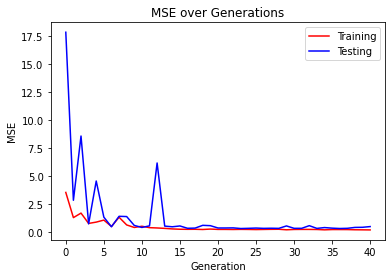

In [ ]:
# Run network without no lifetime learning
no_learning = main(x_test, y_test, x_train, y_train, generations=NUMBER_OF_GENERATIONS)

0.032643385231494904
0.06097831577062607
0.038450971245765686
0.05444561317563057
0.013769295997917652
0.04261436685919762
0.04223736748099327
0.03294634446501732
0.046401653438806534
0.03968251869082451
0.033306971192359924
0.059411536902189255
0.03135410323739052
0.017798976972699165
0.03886109218001366
0.042623911052942276
0.05507330968976021
0.03635760769248009
0.009862714447081089
0.01978672295808792
0.04826618358492851
0.025936400517821312
0.031028451398015022
0.01559701468795538
0.028161024674773216
0.029969004914164543
0.018159864470362663
0.037882715463638306
0.017401237040758133
0.02004964090883732
0.011563858948647976
0.016292927786707878
0.029364848509430885
0.015483451075851917
0.026223478838801384
0.017369745299220085
0.018139002844691277
0.016186298802495003
0.01772756688296795
0.012314035557210445


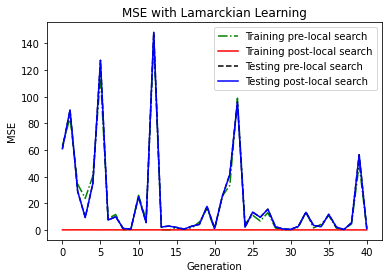

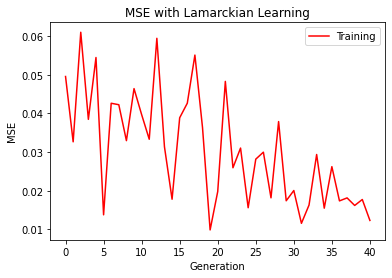

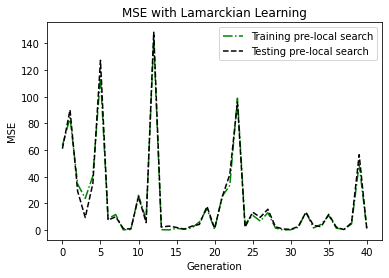

In [ ]:
# Run network using Lamarckian learning
lamarckian = main(x_test, y_test, x_train, y_train, generations=NUMBER_OF_GENERATIONS, learning="Lamarckian")

0.05350184068083763
0.034061942249536514
0.047056760638952255
0.04332781210541725
0.024091875180602074
0.05391109362244606
0.024401014670729637
0.021677417680621147
0.043043188750743866
0.0553411990404129
0.043685879558324814
0.044671572744846344
0.04869230091571808
0.0412122905254364
0.03434063866734505
0.038159411400556564
0.045509275048971176
0.023592345416545868
0.04407278820872307
0.037499282509088516
0.02379908598959446
0.020200444385409355
0.022716619074344635
0.027473419904708862
0.0355972945690155
0.04681621491909027
0.019392462447285652
0.034308671951293945
0.019466053694486618
0.021042250096797943
0.043814729899168015
0.03781416639685631
0.024195872247219086
0.01602252386510372
0.0101515157148242
0.016149019822478294
0.02051030844449997
0.00776942353695631
0.01662832498550415
0.01588466763496399


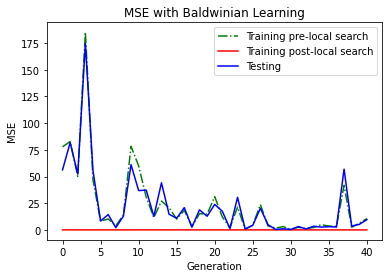

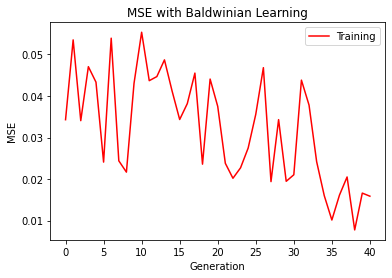

In [ ]:
# Run network using Baldwinian learning
baldwinian = main(x_test, y_test, x_train, y_train, generations=NUMBER_OF_GENERATIONS, learning="Baldwinian")